# CNV Processing

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'cnv_processing')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'cnv_processing')
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)

In [3]:
fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/eval/CopyNumberClass.report.dat'
report = pd.read_table(fn, index_col=0)

## Speedseq CNVs

In [4]:
def read_ss_vcf(fn):
    """Read and parse a lumpy/speedseq vcf."""
    df = pd.read_table(fn, skiprows=47)
    df.columns = [x.replace('#', '') for x in df.columns]
    df = df[df.ALT.apply(lambda x: x in ['<DEL>', '<DUP>'])]
    cols = [x.split('=')[0] for x in df.INFO[0].split(';')]
    imprecise = []
    rows = []
    for i in df.index:
        vals = list(df.ix[i, 'INFO'].split(';'))
        if 'IMPRECISE' in vals:
            imprecise.append(True)
            vals.remove('IMPRECISE')
        else:
            imprecise.append(False)
        rows.append(dict([x.split('=') for x in vals]))
    df['imprecise'] = imprecise
    tdf = pd.DataFrame(rows, index=df.index)
    df = df.join(tdf)
    df = df.drop('INFO', axis=1)
    cols = df.FORMAT[0].split(':')
    ds = df.apply(lambda x: pd.Series(dict(zip(x['FORMAT'].split(':'), x[df.columns[8]].split(':')))), axis=1)
    ds = ds.drop(set(df.columns) & set(ds.columns), axis=1)
    df = df.join(ds)
    df = df.drop(['FORMAT', df.columns[8]], axis=1)
    df.ALT = df.ALT.apply(lambda x: x[1:4])
    df = df[df.END.isnull() == False]
    for c in ['POS', 'END']:
        df[c] = df[c].astype(int)
    for c in ['QUAL', 'PE', 'AB', 'CN', 'SQ', 'SR', 'SU', 'SVLEN', 'AO', 
              'AP', 'AS', 'DP', 'QA', 'QR', 'RO', 'RP', 'RS']:
        df[c] = df[c].astype(float)
    return df

In [7]:
fns = glob.glob('/frazer01/projects/CARDIPS/pipeline/WGS/SS_CNV_Calls2/*/*_filtered_Auto.gt.vcf')
t = []
for fn in fns:
    with open(fn) as f:
        t.append(len(f.readlines()))
se = pd.Series(t, index=fns)
fns = list(set(fns) - set(se[se == 0].index))
dfs = []
for fn in fns:
    dfs.append(read_ss_vcf(fn))

## Genome Strip CNVs

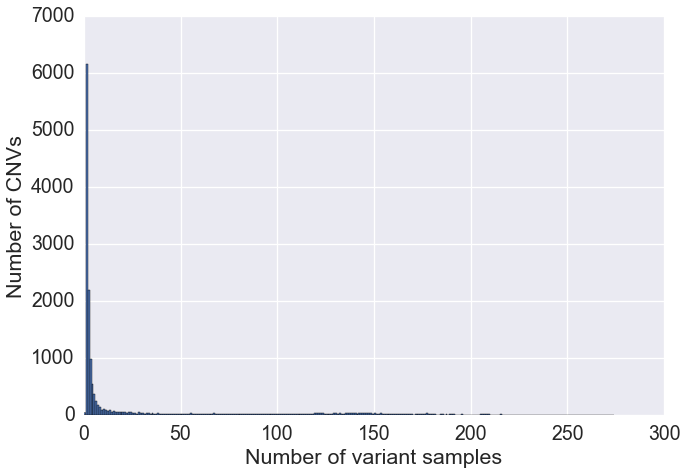

In [63]:
report.NVARIANT.hist(bins=range(275))
plt.ylabel('Number of CNVs')
plt.xlabel('Number of variant samples');

In [12]:
fn = '/projects/CARDIPS/pipeline/WGS/BF_GS_Discovery/gs_cnv.genotypes.vcf'
f = open(fn)
line = f.readline()
while line[0:2] == '##':
    line = f.readline()
header = line[1:].strip().split('\t')

ind = []
copy_numbers = []
line = f.readline().strip()
while line != '':
    t = line.split('\t')
    ind.append(t[2])
    copy_numbers.append([int(x.split(':')[1]) for x in t[9:]])
    line = f.readline().strip()
cns = pd.DataFrame(copy_numbers, index=ind, columns=header[9:])

In [13]:
cnv_info = pd.DataFrame([x.split('_')[1:] for x in cns.index], 
                        index=cns.index, columns=['chrom', 'start', 'end'])
cnv_info['chrom'] = 'chr' + cnv_info.chrom
cnv_info['start'] = cnv_info.start.astype(int)
cnv_info['end'] = cnv_info.end.astype(int)
cnv_info['length'] = cnv_info.end - cnv_info.start
cnv_info['name'] = cnv_info.index
cnv_info.to_csv(os.path.join(outdir, 'cnv_info.tsv'), sep='\t')

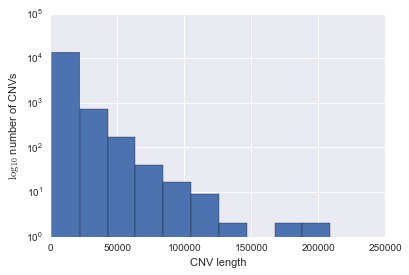

In [31]:
cnv_info.length.hist(log=True)
plt.ylabel('$\log_{10}$ number of CNVs')
plt.xlabel('CNV length');

In [37]:
sns.set_context('talk', font_scale=1.5)

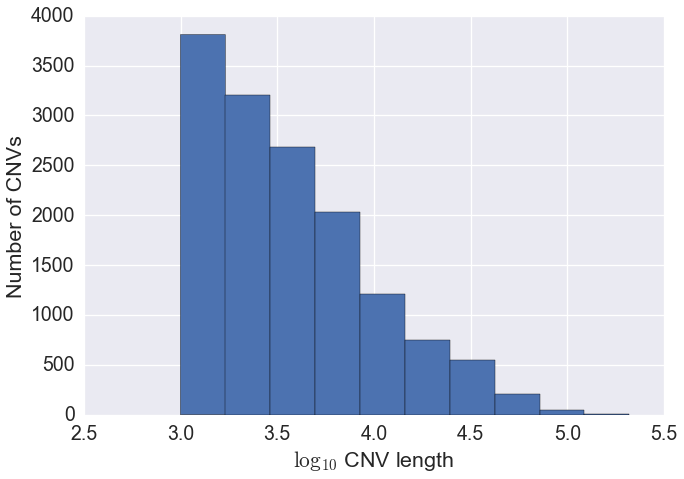

In [38]:
(np.log10(cnv_info.length)).hist()
plt.ylabel('Number of CNVs')
plt.xlabel('$\log_{10}$ CNV length');

In [16]:
cnv_info.length.describe()

count     14500.000000
mean       6615.005931
std       10552.781125
min         999.000000
25%        1660.000000
50%        3049.000000
75%        6574.250000
max      208946.000000
Name: length, dtype: float64

In [36]:
cutoffs = np.array([2, 5, 10, 50, 100, 200]) * 1000
for c in cutoffs:
    print('{:.1f}% of CNVs are less than {:,} bp'.format(
            100 * sum(cnv_info.length < c) / float(cnv_info.shape[0]), c))

32.7% of CNVs are less than 2,000 bp
67.2% of CNVs are less than 5,000 bp
84.1% of CNVs are less than 10,000 bp
99.0% of CNVs are less than 50,000 bp
99.9% of CNVs are less than 100,000 bp
100.0% of CNVs are less than 200,000 bp


## EMMAX CNVs

I want to find CNVs that I can include in the EMMAX association analysis. 
These will be CNVs that have at most three copy number states and have a
minor allele frequency greater than 5%.

I can also separately test mCNVs for an association with gene expression.

In [20]:
cns_f = cns[rna_meta[rna_meta.in_eqtl].wgs_id]
num_states = cns_f.apply(lambda x: len(set(x)), axis=1)
cns_emmax = cns_f.ix[num_states[num_states.apply(lambda x: x in [2, 3])].index]

In [22]:
b = cns_emmax.apply(lambda x: x.value_counts().max() < cns_emmax.shape[1] - np.floor(207 * 0.05), axis=1)
cns_emmax = cns_emmax[b]

In [23]:
maj_af = cns_emmax.apply(lambda x: x.value_counts().max(), axis=1) / cns_emmax.shape[1]

In [24]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

res = cns_emmax_bt.intersect(variant_regions, sorted=True, wo=True)
g = []
for r in res:
    g.append(r.fields[-3].split('_')[0])
cnv_gene_vc = pd.Series(g).value_counts()
cnv_gene_vc = cnv_gene_vc[set(cnv_gene_vc.index) & set(qvalues.index)]

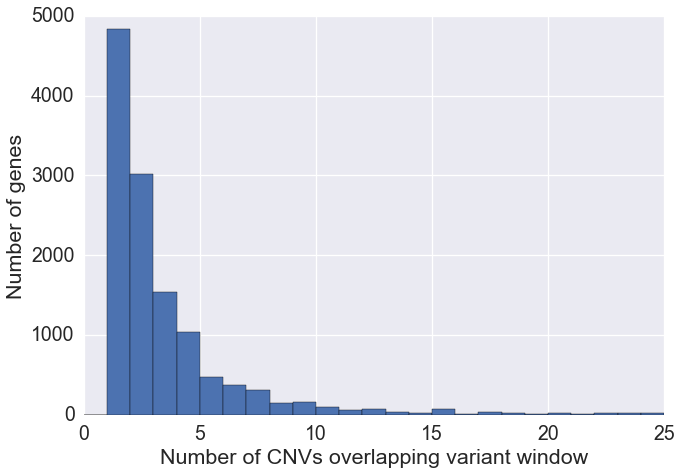

In [39]:
cnv_gene_vc.hist(bins=range(cnv_gene_vc.max()))
plt.ylabel('Number of genes')
plt.xlabel('Number of CNVs overlapping variant window');

I think that I can collapse some mCNVs to be biallelic. For instance, the CNV
below has one person with copy number 4, but if we exclude that person, we would
only have three copy number states. The person who is four is likely just an error and
should actually be 3, or at the least it wouldn't hurt to make them copy number 3 or 
just not include them in the analysis.

In [26]:
report.ix['CNV_19_40372246_40375846']

CALLRATE               0.989
CNMIN                      1
CNMAX                      4
CNALLELES                  3
NNONREF                  140
NVARIANT                 140
CNCATEGORY             MIXED
CNDIST        0,109,131,30,1
Name: CNV_19_40372246_40375846, dtype: object

In [40]:
t = cns_f.ix[set(cns_f.index) - set(cns_emmax.index)]
t = t[t.apply(lambda x: len(set(x)) > 3, axis=1)]
b = t.apply(lambda x: x.value_counts()[0:3].sum(), axis=1)

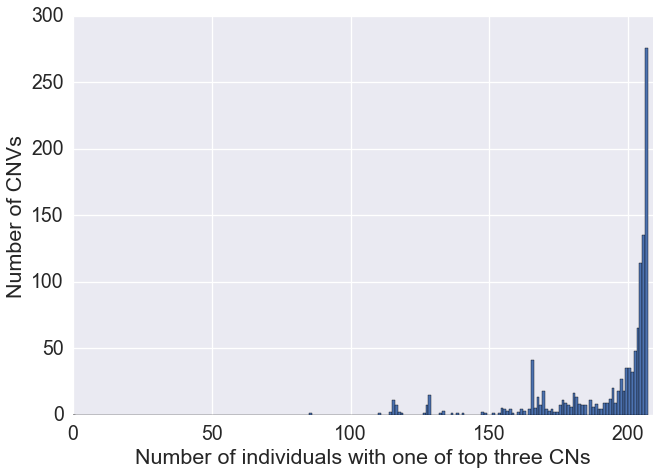

In [41]:
b.hist(bins=range(208))
plt.xlim(0, 209)
plt.ylabel('Number of CNVs')
plt.xlabel('Number of individuals with one of top three CNs');

This plot shows us that many CNVs are almost biallelic. If we remove 
a few samples, we can make more sites biallelic.

In [42]:
sum(b >= 197)

785

There are 785 CNVs for which I can remove people with rare copy numbers
and still have 95% call rate. I'll set the rare copy numbers to missing
and include these.

In [46]:
rows = []
for i in b[b >= 197].index:
    se = cns_f.ix[i]
    vc = se.value_counts()
    se[se.apply(lambda x: x not in vc.index[0:3])] = np.nan
    rows.append(se)
df = pd.DataFrame(rows, index=b[b >= 197].index, 
                  columns=cns_f.columns)

In [47]:
b = df.apply(lambda x: x.value_counts().max() < df.shape[1] - np.floor(207 * 0.05), axis=1)
df = df[b]

In [48]:
cns_emmax = pd.concat([cns_emmax, df])
cns_emmax.to_csv(os.path.join(private_outdir, 'emmax_cnvs.tsv'), sep='\t')

In [49]:
cns_emmax.shape

(3183, 207)

I'll write a VCF file with the CNV genotypes.

In [50]:
cns_emmax_genotypes = cns_emmax.copy(deep=True).astype(str)
mins = cns_emmax.apply(lambda x: x == x.min(), axis=1)
maxs = cns_emmax.apply(lambda x: x == x.max(), axis=1)
nulls = cns_emmax.isnull()
hets = (mins.astype(int) + maxs.astype(int) + nulls.astype(int) == 0)
cns_emmax_genotypes[mins] = '0/0'
cns_emmax_genotypes[hets] = '0/1'
cns_emmax_genotypes[maxs] = '1/1'
cns_emmax_genotypes[nulls] = './.'

In [51]:
cns_emmax_info = cnv_info.ix[cns_emmax.index]
cns_emmax_info.chrom = cns_emmax_info.chrom.apply(lambda x: x[3:])
cns_emmax_info = cns_emmax_info.drop(['end', 'length'], axis=1)
cns_emmax_info.start = cns_emmax_info.start.astype(str)
cns_emmax_info['ref'] = 'N'
cns_emmax_info['alt'] = 'N'
cns_emmax_info['qual'] = '100000'
cns_emmax_info['filter'] = 'PASS'
cns_emmax_info['info'] = ''
cns_emmax_info['format'] = 'GT'
cns_emmax_info = cns_emmax_info.join(cns_emmax_genotypes[sorted(cns_emmax_genotypes.columns)])

In [ ]:
with open('/projects/CARDIPS/analysis/cardips-ipsc-eqtl/scripts/header.vcf') as f:
    lines = f.readlines()
vs = lines[-1].strip().split('\t')[9:]
colnames = lines[-1].strip().split('\t')[0:9]

In [ ]:
with open(os.path.join(private_outdir, 'emmax.vcf'), 'w') as f:
    f.write(''.join(lines[0:-1]))
    f.write('\t'.join(colnames + list(cns_emmax_info.columns[9:])) + '\n')
    f.write('\n'.join(cns_emmax_info.apply(lambda x: '\t'.join(x), axis=1)) + '\n')
out = os.path.join(private_outdir, 'emmax_sorted.vcf')
!cat {os.path.join(private_outdir, 'emmax.vcf')} | vcf-sort > {out}
!bgzip {out}
!bcftools index {out}.gz
!bcftools index -t {out}.gz
!rm {os.path.join(private_outdir, 'emmax.vcf')}

Let's see which genes have CNVs to test now that we've added in some more CNVs.

In [52]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

res = cns_emmax_bt.intersect(variant_regions, sorted=True, wo=True)
g = []
for r in res:
    g.append(r.fields[-3].split('_')[0])
cnv_gene_vc = pd.Series(g).value_counts()
cnv_gene_vc = cnv_gene_vc[set(cnv_gene_vc.index) & set(qvalues.index)]

In [53]:
t = cnv_info.ix[cns_emmax.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
cns_emmax_bt = pbt.BedTool(s, from_string=True)
cns_emmax_bt = cns_emmax_bt.sort()

In [54]:
cnv_gene_vc.shape

(12829,)

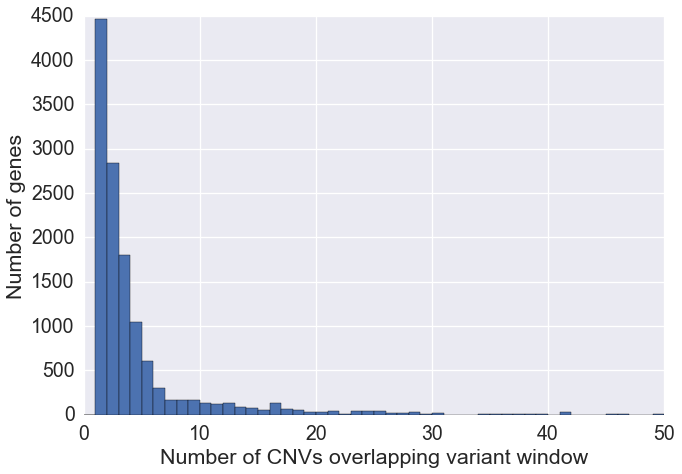

In [55]:
cnv_gene_vc.hist(bins=range(cnv_gene_vc.max()))
plt.ylabel('Number of genes')
plt.xlabel('Number of CNVs overlapping variant window');

In [56]:
done = set(qvalues.index) - set(cnv_gene_vc.index)

In [ ]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

In [ ]:
c = chunks(list(done), 100)

In [ ]:
len(done)

In [ ]:
gs = c.next()

In [ ]:
with open(os.path.join(ciepy.root, 'sandbox', 'copy.sh'), 'w') as f:
    while True:
        try:
            gs = c.next()
        except StopIteration:
            break
        dys = ['/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/run_eqtl_analysis/results/{}'.format(x)
               for x in gs]
        command = 'cp -r {} /projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/run_eqtl_analysis/results\n'.format(' '.join(dys))
        f.write(command)

## mCNVs

I want to identify mCNVs that I can test for associations with gene expression. 
I'll filter the mCNVs more in the notebook where I do the analysis.

In [ ]:
mcnvs = cns_f.ix[num_states[num_states > 3].index]
mcnvs_f = mcnvs_f.ix[set(mcnvs_f.index) - set(cns_emmax.index)]
mcnvs_f.to_csv(os.path.join(private_outdir, 'mcnvs.tsv'), sep='\t')